In [64]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download squeakink/mpiifacegaze


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
mpiifacegaze.zip: Skipping, found more recently modified local copy (use --force to force download)


In [65]:
!unzip mpiifacegaze

Archive:  mpiifacegaze.zip
  inflating: MPIIFaceGaze.h5         


In [70]:
import random
import numpy as np
import random
import torch
import os

seed = 777

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

batch_size = 32
optimizer = 'sgd'
epochs = 15
test_id = 0
num_workers = 2
drop_last = True
pin_memory = False

if torch.cuda.is_available():
    available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
    print(available_gpus)

In [71]:
from typing import Callable, Tuple
import h5py
from torch.utils.data import Dataset


class OnePersonDataset(Dataset):
    def __init__(self, person_id_str, dataset_path,
                 transform: Callable):
        self.person_id_str = person_id_str
        self.dataset_path = dataset_path
        self.transform = transform

    def __getitem__(
            self,
            index: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        with h5py.File(self.dataset_path, 'r') as f:
            image = f.get(f'{self.person_id_str}/image/{index:04}')[()]
            pose = f.get(f'{self.person_id_str}/pose/{index:04}')[()]
            gaze = f.get(f'{self.person_id_str}/gaze/{index:04}')[()]
        image = self.transform(image)
        pose = torch.from_numpy(pose)
        gaze = torch.from_numpy(gaze)
        return image, pose, gaze

    def __len__(self) -> int:
        return 3000

In [72]:
from typing import Any

import cv2
import numpy as np
import torch
import torchvision

def trans(x):
    return x.transpose(2, 0, 1)

def scale(x):
    return x.astype(np.float32) / 255

def _create_mpiifacegaze_transform() -> Any:
    transform = torchvision.transforms.Compose([
        trans,
        scale,
        torch.from_numpy,
        torchvision.transforms.Normalize(mean=[0.406, 0.456, 0.485],
                                         std=[0.225, 0.224, 0.229]),
    ])
    return transform

In [74]:
from typing import Tuple, Union
from torch.utils.data import DataLoader

#dataset_dir = '/kaggle/input/mpiifacegaze/MPIIFaceGaze.h5'
dataset_dir = '/content/MPIIFaceGaze.h5'

val_ratio =  0.1


def create_dataset():
    person_ids = [f'p{index:02}' for index in range(15)]

    transform = _create_mpiifacegaze_transform()
    if test_id == -1:
        train_dataset = torch.utils.data.ConcatDataset([
            OnePersonDataset(person_id, dataset_dir, transform)
            for person_id in person_ids
        ])
        assert len(train_dataset) == 45000
    else:
        test_person_id = person_ids[test_id]
        train_dataset = torch.utils.data.ConcatDataset([
            OnePersonDataset(person_id, dataset_dir, transform)
            for person_id in person_ids if person_id != test_person_id
        ])
        assert len(train_dataset) == 42000

    assert val_ratio < 1
    val_num = int(len(train_dataset) * val_ratio)
    train_num = len(train_dataset) - val_num
    lengths = [train_num, val_num]
    return torch.utils.data.dataset.random_split(train_dataset, lengths)

def create_dataloader() -> Union[Tuple[DataLoader, DataLoader], DataLoader]:
    train_dataset, val_dataset = create_dataset()
    # print(train_dataset.__getitem__(0)[0].shape)
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=pin_memory,
        drop_last=drop_last,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=pin_memory,
        drop_last=drop_last,
    )
    return train_loader, val_loader

train_loader, val_loader = create_dataloader()
test_loader = OnePersonDataset('p00', dataset_dir, _create_mpiifacegaze_transform())


In [104]:

train_entries = len(train_loader.dataset)
val_entries = len(val_loader.dataset)
test_entries = len(test_loader)

print("Number of entries in the train loader:", train_entries)
print("Number of entries in the val loader:", val_entries)
print("Number of entries in the test loader:", test_entries)
print("tot: ", train_entries + val_entries + test_entries)

Number of entries in the train loader: 37800
Number of entries in the val loader: 4200
Number of entries in the test loader: 3000
tot:  45000


In [101]:
from typing import Optional, Tuple, Union

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import cv2



class alexnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = torchvision.models.alexnet(
            weights=True).features
        # While the pretrained models of torchvision are trained using
        # images with RGB channel order, in this repository images are
        # treated as BGR channel order.
        # Therefore, reverse the channel order of the first convolutional
        # layer.
        module = getattr(self.feature_extractor, '0')
        module.weight.data = module.weight.data[:, [2, 1, 0]]

        self.conv1 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0)
        self.conv2 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0)
        self.conv3 = nn.Conv2d(256, 1, kernel_size=1, stride=1, padding=0)

        self.fc1 = nn.Linear(256 * 13**2, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 2)

        self._register_hook()
        self._initialize_weight()

    def _initialize_weight(self) -> None:
        nn.init.normal_(self.conv1.weight, mean=0, std=0.01)
        nn.init.normal_(self.conv2.weight, mean=0, std=0.01)
        nn.init.normal_(self.conv3.weight, mean=0, std=0.001)
        nn.init.constant_(self.conv1.bias, val=0.1)
        nn.init.constant_(self.conv2.bias, val=0.1)
        nn.init.constant_(self.conv3.bias, val=1)
        nn.init.normal_(self.fc1.weight, mean=0, std=0.005)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.0001)
        nn.init.normal_(self.fc3.weight, mean=0, std=0.0001)
        nn.init.constant_(self.fc1.bias, val=1)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)

    def _register_hook(self) -> None:
        n_channels = self.conv1.in_channels

        def hook(
            module: nn.Module, grad_in: Union[Tuple[torch.Tensor, ...],
                                              torch.Tensor],
            grad_out: Union[Tuple[torch.Tensor, ...], torch.Tensor]
        ) -> Optional[torch.Tensor]:
            return tuple(grad / n_channels for grad in grad_in)

        self.conv3.register_backward_hook(hook)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        img = x[0].cpu().detach().numpy()
        img = np.transpose(img, (1, 2, 0))
        x = self.feature_extractor(x)
        y = F.relu(self.conv1(x))
        y = F.relu(self.conv2(y))
        y = F.relu(self.conv3(y))
        test = y[0].cpu().detach().numpy()
        reshaped_vector = np.reshape(test, (13, 13))
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(reshaped_vector)
        plt.subplot(1, 2, 2)
        plt.imshow(img)
        x = x * y
        x = x.view(x.size(0), -1)
        x = F.dropout(F.relu(self.fc1(x)), p=0.5, training=self.training)
        x = F.dropout(F.relu(self.fc2(x)), p=0.5, training=self.training)
        x = self.fc3(x)
        return x

In [33]:
from typing import Optional, Tuple, Union

import torch
import torch.nn as nn
import torch.nn.functional as F


import torch
import torchvision


class res_net_backbone(torchvision.models.ResNet):
    def __init__(self):
        block = torchvision.models.resnet.BasicBlock
        layers = [2, 2, 2] + [1]
        super().__init__(block, layers)
        del self.layer4
        del self.avgpool
        del self.fc

        pretrained_name = "resnet18"
        if pretrained_name:
            # Load the appropriate ResNet model using the available functions
            pretrained_model = getattr(torchvision.models, pretrained_name)(pretrained=True)
            # Get the state dict from the loaded pretrained model
            state_dict = pretrained_model.state_dict()

            self.load_state_dict(state_dict, strict=False)
            # While the pretrained models of torchvision are trained
            # using images with RGB channel order, in this repository
            # images are treated as BGR channel order.
            # Therefore, reverse the channel order of the first
            # convolutional layer.
            module = self.conv1
            module.weight.data = module.weight.data[:, [2, 1, 0]]

        with torch.no_grad():
            data = torch.zeros((1, 3, 224, 224), dtype=torch.float32)
            features = self.forward(data)
            self.n_features = features.shape[1]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x


class resNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = res_net_backbone()
        n_channels = self.feature_extractor.n_features

        self.conv = nn.Conv2d(n_channels,
                              1,
                              kernel_size=1,
                              stride=1,
                              padding=0)
        # This model assumes the input image size is 224x224.
        self.fc = nn.Linear(n_channels * 14**2, 2)

        self._register_hook()
        self._initialize_weight()

    def _initialize_weight(self) -> None:
        nn.init.kaiming_normal_(self.conv.weight)
        nn.init.zeros_(self.conv.bias)
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def _register_hook(self):
        n_channels = self.feature_extractor.n_features

        def hook(
            module: nn.Module, grad_in: Union[Tuple[torch.Tensor, ...],
                                              torch.Tensor],
            grad_out: Union[Tuple[torch.Tensor, ...], torch.Tensor]
        ) -> Optional[torch.Tensor]:
            return tuple(grad / n_channels for grad in grad_in)

        self.conv.register_backward_hook(hook)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.feature_extractor(x)
        y = F.relu(self.conv(x))
        x = x * y
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [34]:
!pip install fvcore

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
import random
from typing import Tuple
import pathlib
import numpy as np
import torch


def setup_cudnn(config) -> None:
    torch.backends.cudnn.benchmark = config.cudnn.benchmark
    torch.backends.cudnn.deterministic = config.cudnn.deterministic

def create_train_output_dir(config):
    output_root_dir = pathlib.Path(config.train.output_dir)
    if config.train.test_id != -1:
        output_dir = output_root_dir / f'{config.train.test_id:02}'
    else:
        output_dir = output_root_dir / 'all'
    if output_dir.exists():
        raise RuntimeError(
            f'Output directory `{output_dir.as_posix()}` already exists.')
    output_dir.mkdir(exist_ok=True, parents=True)
    return output_dir


def convert_to_unit_vector(
        angles: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    pitches = angles[:, 0]
    yaws = angles[:, 1]
    x = -torch.cos(pitches) * torch.sin(yaws)
    y = -torch.sin(pitches)
    z = -torch.cos(pitches) * torch.cos(yaws)
    norm = torch.sqrt(x**2 + y**2 + z**2)
    x /= norm
    y /= norm
    z /= norm
    return x, y, z


def compute_angle_error(predictions: torch.Tensor,
                        labels: torch.Tensor) -> torch.Tensor:
    pred_x, pred_y, pred_z = convert_to_unit_vector(predictions)
    label_x, label_y, label_z = convert_to_unit_vector(labels)
    angles = pred_x * label_x + pred_y * label_y + pred_z * label_z
    return torch.acos(angles) * 180 / np.pi


class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, num):
        self.val = val
        self.sum += val * num
        self.count += num
        self.avg = self.sum / self.count

In [36]:
import time

def train(epoch, model, optimizer, scheduler, loss_function, train_loader, tensorboard_writer):
    print(f'Train {epoch}')

    model.train()

    device = torch.device(_device)

    loss_meter = AverageMeter()
    angle_error_meter = AverageMeter()
    start = time.time()

    for step, (images, poses, gazes) in enumerate(train_loader):
        images = images.to(device)
        poses = poses.to(device)
        gazes = gazes.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_function(outputs, gazes)
        loss.backward()

        optimizer.step()

        angle_error = compute_angle_error(outputs, gazes).mean()

        num = images.size(0)
        loss_meter.update(loss.item(), num)
        angle_error_meter.update(angle_error.item(), num)

        if step % 100 == 0:
            print(f'Epoch {epoch} \n',
                  f'Step {step}/{len(train_loader)} \n',
                  f'lr {scheduler.get_last_lr()[0]:.6f} \n',
                  f'loss {loss_meter.val:.4f} ({loss_meter.avg:.4f}) \n',
                  f'angle error {angle_error_meter.val:.2f} ',
                  f'({angle_error_meter.avg:.2f})\n')

    elapsed = time.time() - start
    print(f'Elapsed {elapsed:.2f}')

    tensorboard_writer.add_scalar('Train/Loss', loss_meter.avg, epoch)
    tensorboard_writer.add_scalar('Train/lr', scheduler.get_last_lr()[0], epoch)
    tensorboard_writer.add_scalar('Train/AngleError', angle_error_meter.avg, epoch)
    tensorboard_writer.add_scalar('Train/Time', elapsed, epoch)

    return loss_meter.avg, angle_error_meter.avg



def validate(epoch, model, loss_function, val_loader,
             tensorboard_writer):
    print(f'Val {epoch}')

    model.eval()

    device = torch.device(_device)

    loss_meter = AverageMeter()
    angle_error_meter = AverageMeter()
    start = time.time()

    with torch.no_grad():
        for step, (images, poses, gazes) in enumerate(val_loader):

            images = images.to(device)
            poses = poses.to(device)
            gazes = gazes.to(device)

            outputs = model(images)

            loss = loss_function(outputs, gazes)

            angle_error = compute_angle_error(outputs, gazes).mean()

            num = images.size(0)
            loss_meter.update(loss.item(), num)
            angle_error_meter.update(angle_error.item(), num)

    print(f'Epoch {epoch} \n',
          f'loss {loss_meter.avg:.4f} \n'
          f'angle error {angle_error_meter.avg:.2f}')

    elapsed = time.time() - start
    print(f'Elapsed {elapsed:.2f}')

    if epoch > 0:
        tensorboard_writer.add_scalar('Val/Loss', loss_meter.avg, epoch)
        tensorboard_writer.add_scalar('Val/AngleError', angle_error_meter.avg,
                                      epoch)
    tensorboard_writer.add_scalar('Val/Time', elapsed, epoch)

    return loss_meter.avg, angle_error_meter.avg

In [12]:
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 14.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3


Val 0


<ipython-input-101-8746312caea0>:71: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


KeyboardInterrupt: ignored

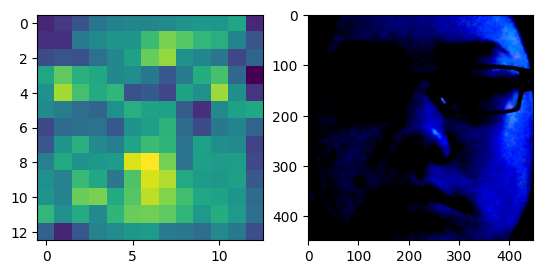

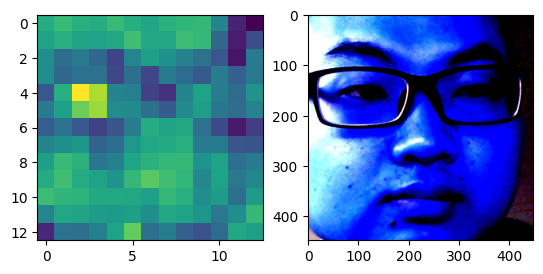

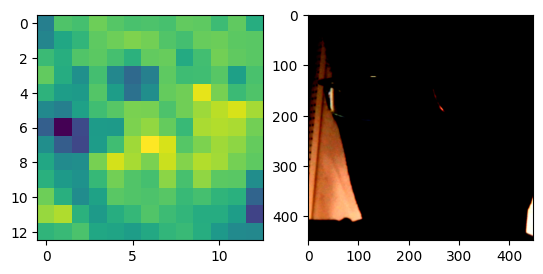

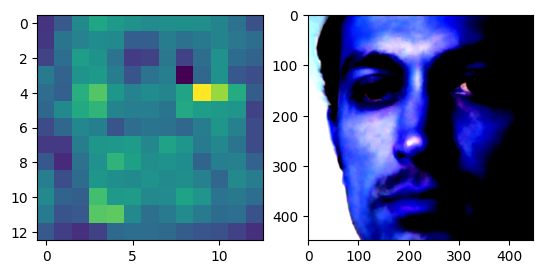

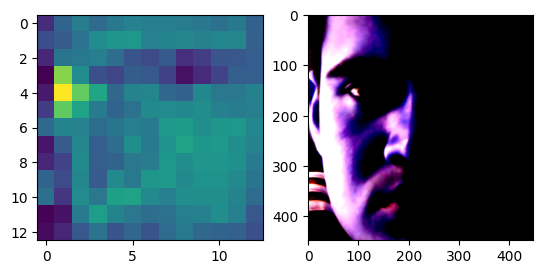

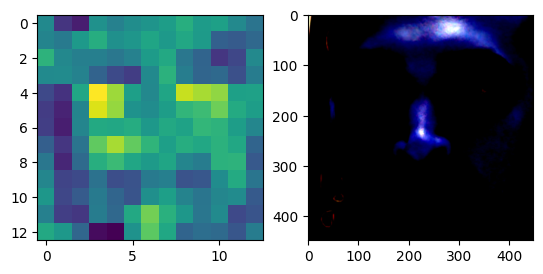

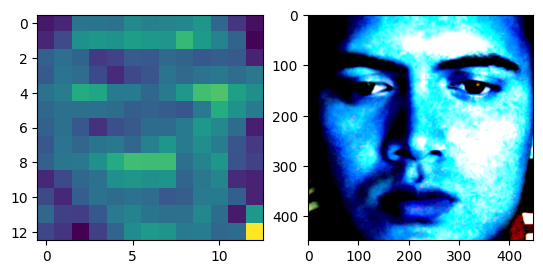

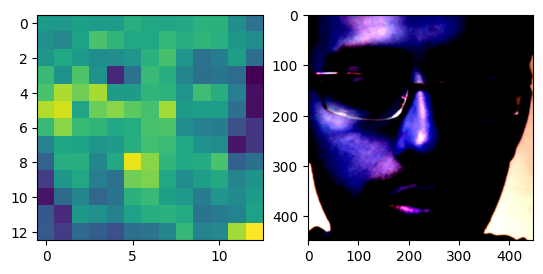

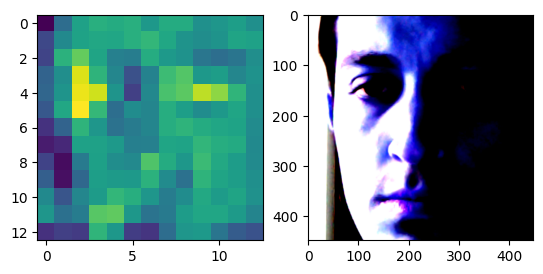

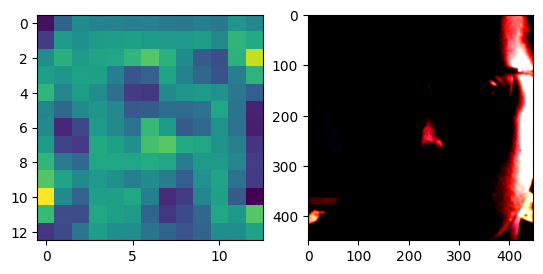

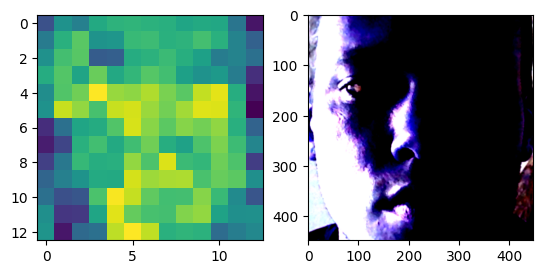

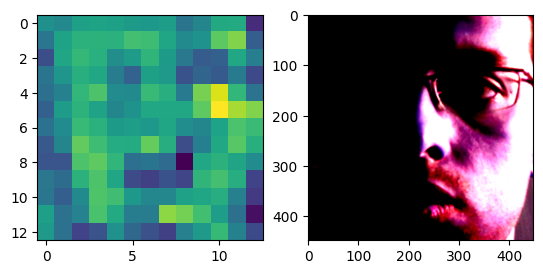

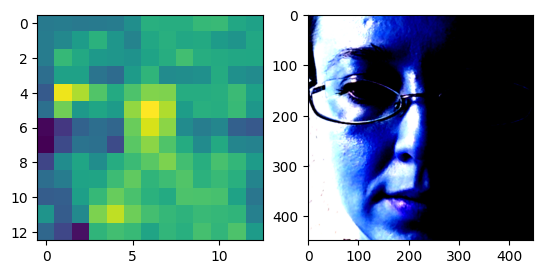

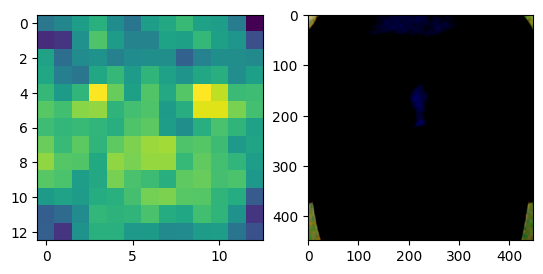

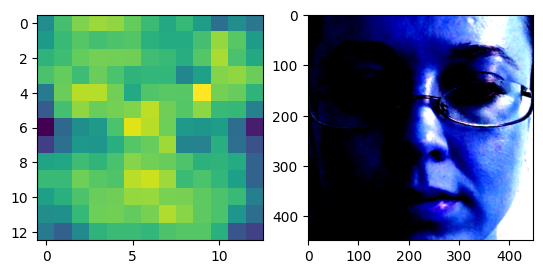

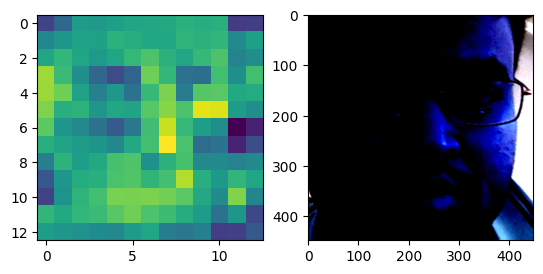

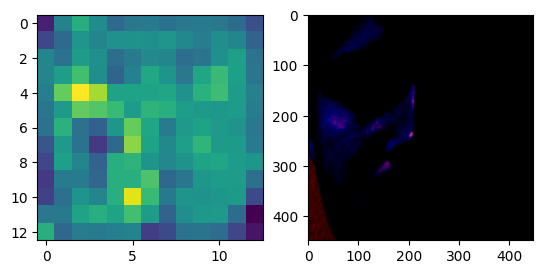

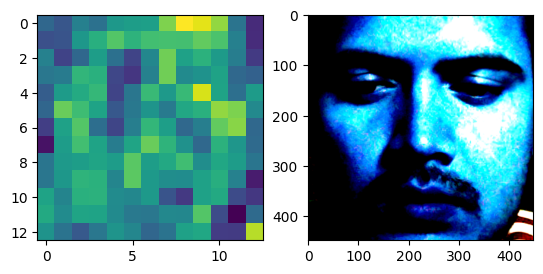

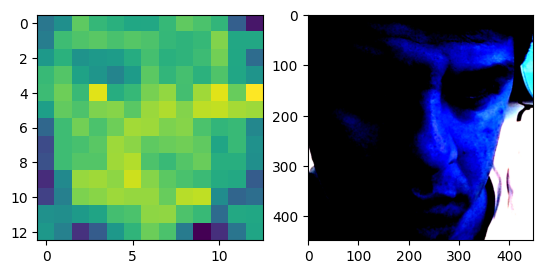

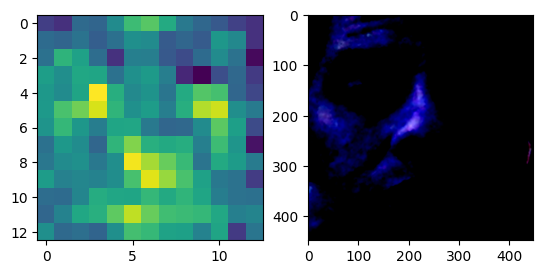

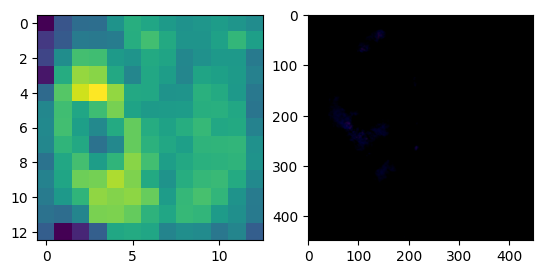

In [102]:
import torch
import torch.nn as nn
from fvcore.common.checkpoint import Checkpointer
from tensorboardX import SummaryWriter

model = alexnet()

_device = 'cuda:0'

device = torch.device(_device)
model.to(device)

loss_fc = nn.L1Loss(reduction='mean')

#output_dir = '/kaggle/working/results/'
output_dir = './'
params = [{'params': list(model.parameters()), 'weight_decay': 0.0001,}]

optimizer = torch.optim.SGD(params,
                            lr=0.01,
                            momentum=0.9,
                            nesterov=True)

scheduler = torch.optim.lr_scheduler.MultiStepLR(
            optimizer,
            milestones=[10, 13],
            gamma=0.1)

checkpointer = Checkpointer(model,
                            optimizer=optimizer,
                            scheduler=scheduler,
                            save_dir=output_dir,
                            save_to_disk=True)

tensorboard_writer = SummaryWriter(output_dir)

validate(0, model, loss_fc, val_loader,
                 tensorboard_writer)


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(1, epochs + 1):
    train_loss, train_accuracy = train(epoch, model, optimizer, scheduler, loss_fc, train_loader, tensorboard_writer)
    scheduler.step()

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    if epoch % 1 == 0:
        val_loss, val_accuracy = validate(epoch, model, loss_fc, val_loader, tensorboard_writer)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

    if (epoch % 5 == 0 or epoch == epochs):
        config = {
            'batch_size': 32,
            'optimizer': 'sgd',
            'epochs': 15,
            'test_id': 0,
            'num_workers': 2,
            'drop_last': True,
            'pin_memory': False
        }
        checkpoint_config = {'epoch': epoch, 'config': config}
        checkpointer.save(f'checkpoint_{epoch:04d}', **checkpoint_config)

tensorboard_writer.close()

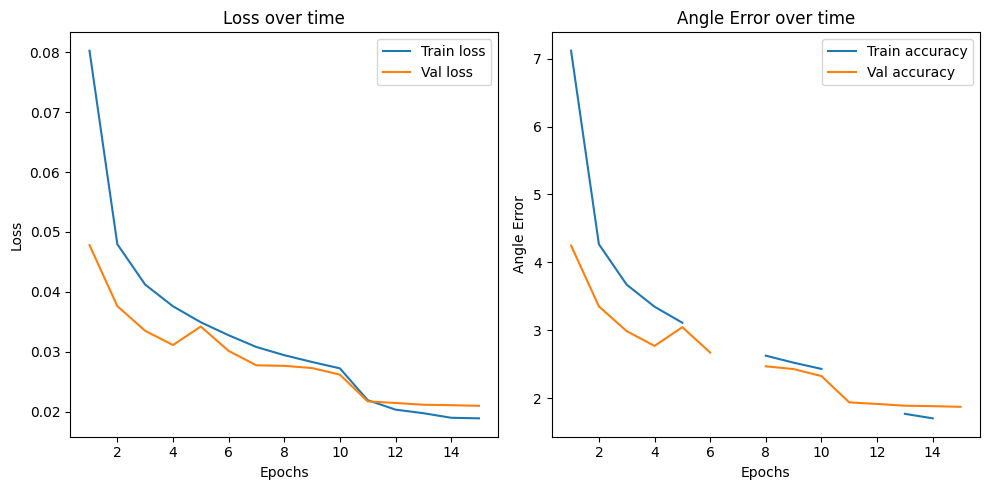

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train loss')
plt.plot(range(1, epochs+1), val_losses, label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over time')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Angle Error')
plt.title('Angle Error over time')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
import torch.nn as nn

model = alexnet()
checkpoint = torch.load("checkpoint_0015.pth",  map_location='cuda')
model.load_state_dict(checkpoint['model'])
model.to(torch.device('cuda'))
loss_fc = nn.L1Loss(reduction='mean')

def evaluate(model, dataloader, criterion, device):
    model.eval()  # set the model to evaluation mode
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():  # disable gradient calculation
        for step, (images, poses, gazes) in enumerate(dataloader):
            inputs = images.to(device)
            targets = gazes.to(device)
            print(images.shape)
            outputs = model(inputs)
            loss = nn.L1loss(outputs, targets)

            _, predicted = torch.max(outputs, 1)
            correct = (predicted == targets).sum().item()
            samples = targets.size(0)

            total_loss += loss.item() * samples
            total_correct += correct
            total_samples += samples

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples

    return avg_loss, accuracy


test_loss, test_accuracy = evaluate(model, test_loader, loss_fc, 'cuda')
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


torch.Size([3, 448, 448])


RuntimeError: ignored